<a href="https://colab.research.google.com/github/Minaa96/PPPO/blob/main/Klasifikacija_pasa_Mina_Lazic_IT81_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prvo je bilo potrebno instalirati novu verziju gdown-a, jer nije hteo da otvori link.



In [6]:
pip install --upgrade --no-cache-dir gdown


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


**IMPORTI**

Definisanje neophodnih biblioteka za dalji rad

In [7]:
!gdown --fuzzy https://drive.google.com/file/d/16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl/view

Downloading...
From: https://drive.google.com/uc?id=16_SPk4CIhL5tL9e3LVnzdyUT_UIwKWDl
To: /content/#6.zip
100% 724M/724M [00:11<00:00, 63.1MB/s]


Unzip seta sa podacima

In [8]:
!unzip "/content/#6.zip" -d "/content/unzipped"


Streaming output truncated to the last 5000 lines.
  inflating: /content/unzipped/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: /content/unzipped/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: /content/unzipped/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: /content/unzipped/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: /content/unzipped/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: /content/unzipped/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: /content/unzipped/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: /content/unzipped/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: /content/unzipped/train/83fad0718581a696132c96c166472627.jpg  
  inflating: /content/unzipped/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: /content/unzipped/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: /content/unzipped/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: /content/unzipped/train/

Import potrebnih biblioteka

In [9]:
import numpy as np 
import pandas as pd 
import os, cv2, random, time, shutil, csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gc
from tqdm import tqdm
from google.colab.patches import cv2_imshow


import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

Definicija funkcije koja broji sve fajlove u folderu

In [10]:
def get_num_files(path):
    if not os.path.exists(path):
        return 0
    return sum([len(files) for r, d, files in os.walk(path)])

Ucitavanje direktorijuma sa podacima i prikazivanje broja slika za test i trening podatke

In [27]:
train_dir = '/content/unzipped/train'
test_dir = '/content/unzipped/test'

data_size = get_num_files(train_dir)
test_size = get_num_files(test_dir)
print("Numbers of dog's images in train directory: ", data_size)
print("Numbers of dog's images in test directory: ", test_size)

Numbers of dog's images in train directory:  10222
Numbers of dog's images in test directory:  10357


Pregled podataka

In [26]:
labels_dataframe = pd.read_csv('/content/unzipped/labels.csv')

sample_df = pd.read_csv('/content/unzipped/sample_submission.csv')


labels_dataframe.head(15)



,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


**Prikaz jedne fotografije iz dataset-a**

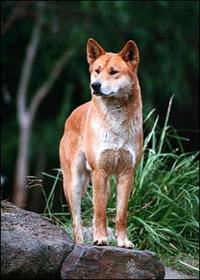

In [13]:
path = "/content/unzipped/train/00a338a92e4e7bf543340dc849230e75.jpg"
img = cv2.imread(path)
cv2_imshow(img)

Citanje jedinstvenih rasa i broj pasa za odredjene rase

In [30]:
unique_breeds = labels_dataframe["breed"].value_counts()
print('Total number of dogs in unique breeds: ', unique_breeds)

Total number of dogs in unique breeds:  scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64


Dijagramski prikaz zastupljenosti rase

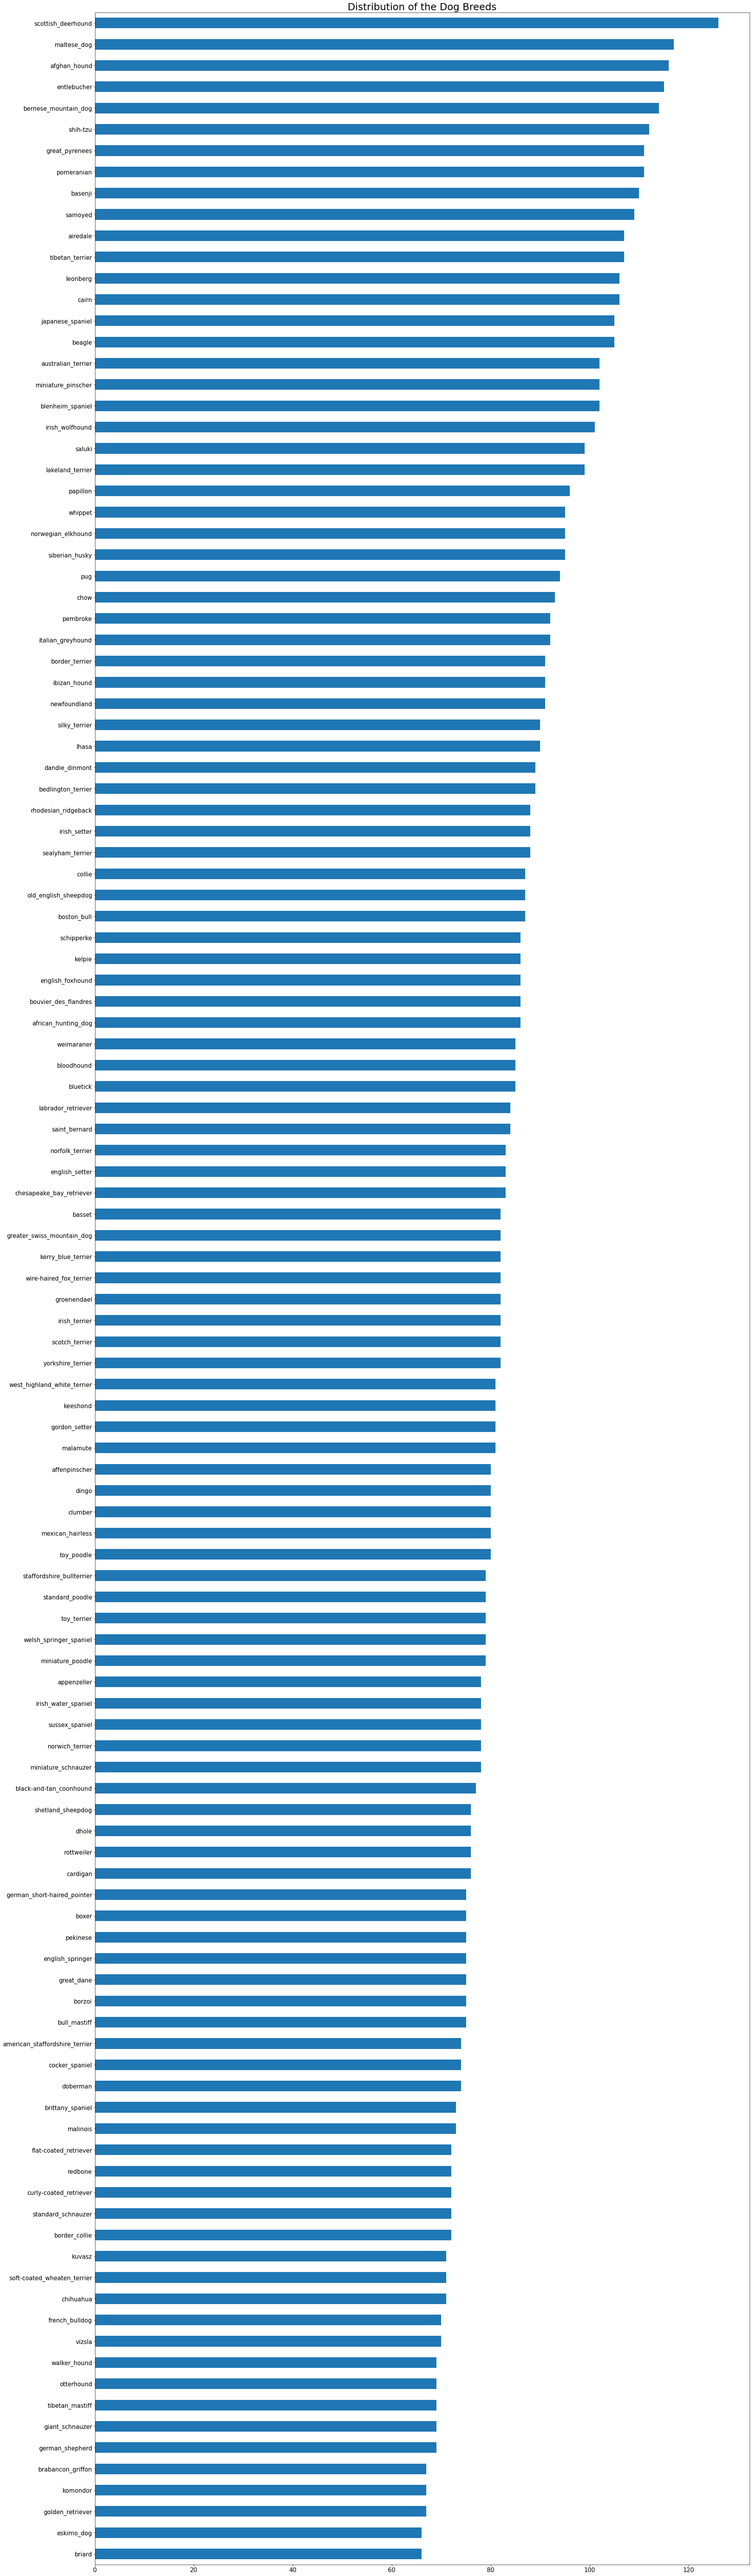

In [16]:
bar = labels_dataframe["breed"].value_counts(ascending=True).plot.barh(figsize = (30,120))
plt.title("Distribution of the Dog Breeds", fontsize = 25)
bar.tick_params(labelsize=15)
plt.show()

Sortiranje liste rasa i prikaz prvih 15

In [31]:
dog_breeds = sorted(list(set(labels_dataframe['breed'])))
n_classes = len(dog_breeds)
print('Total number of unique breeds: ', n_classes)
dog_breeds[:15]

Total number of unique breeds:  120


['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound']

**Definicija recnika pojmova** 

In [44]:
class_to_num = dict(zip(dog_breeds, range(n_classes)))


**One hot encoding**

Definicija funkcije za smeštanje fotografija u niz

*Inicijalizacija X i Y "niza" na to da x predstavlja broj slika i prikazuje njihovu rezoluciju (3d matricu piksela) i y niza koji predstavlja broj slika kao i broj različitih label-a (različitih rasa)*.

In [35]:
def images_to_array(data_dir, labels_dataframe, img_size = (224,224,3)):

    images_names = labels_dataframe['id']
    images_labels = labels_dataframe['breed']
    data_size = len(images_names)
    #initailize output arrays.
    X = np.zeros([data_size, img_size[0], img_size[1], img_size[2]], dtype=np.uint8)
    y = np.zeros([data_size,1], dtype=np.uint8)
    #read data and labels.
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
        image_breed = images_labels[i]
        y[i] = class_to_num[image_breed]
    
    
    y = to_categorical(y)
    #shuffle    
    ind = np.random.permutation(data_size)
    X = X[ind]
    y = y[ind]
    print('Ouptut Data Size: ', X.shape)
    print('Ouptut Label Size: ', y.shape)
    return X, y
    gc.collect()

**`Definicija rezolucije fotografija `**

*Da ne bi postojale fotografije na ulazu koje su razlicitih rezolucija.*

In [36]:
img_size = (250,250,3)
X, y = images_to_array(train_dir, labels_dataframe, img_size)

100%|██████████| 10222/10222 [00:36<00:00, 278.92it/s]


Ouptut Data Size:  (10222, 250, 250, 3)
Ouptut Label Size:  (10222, 120)


Prikaz fotografija nakon obrade

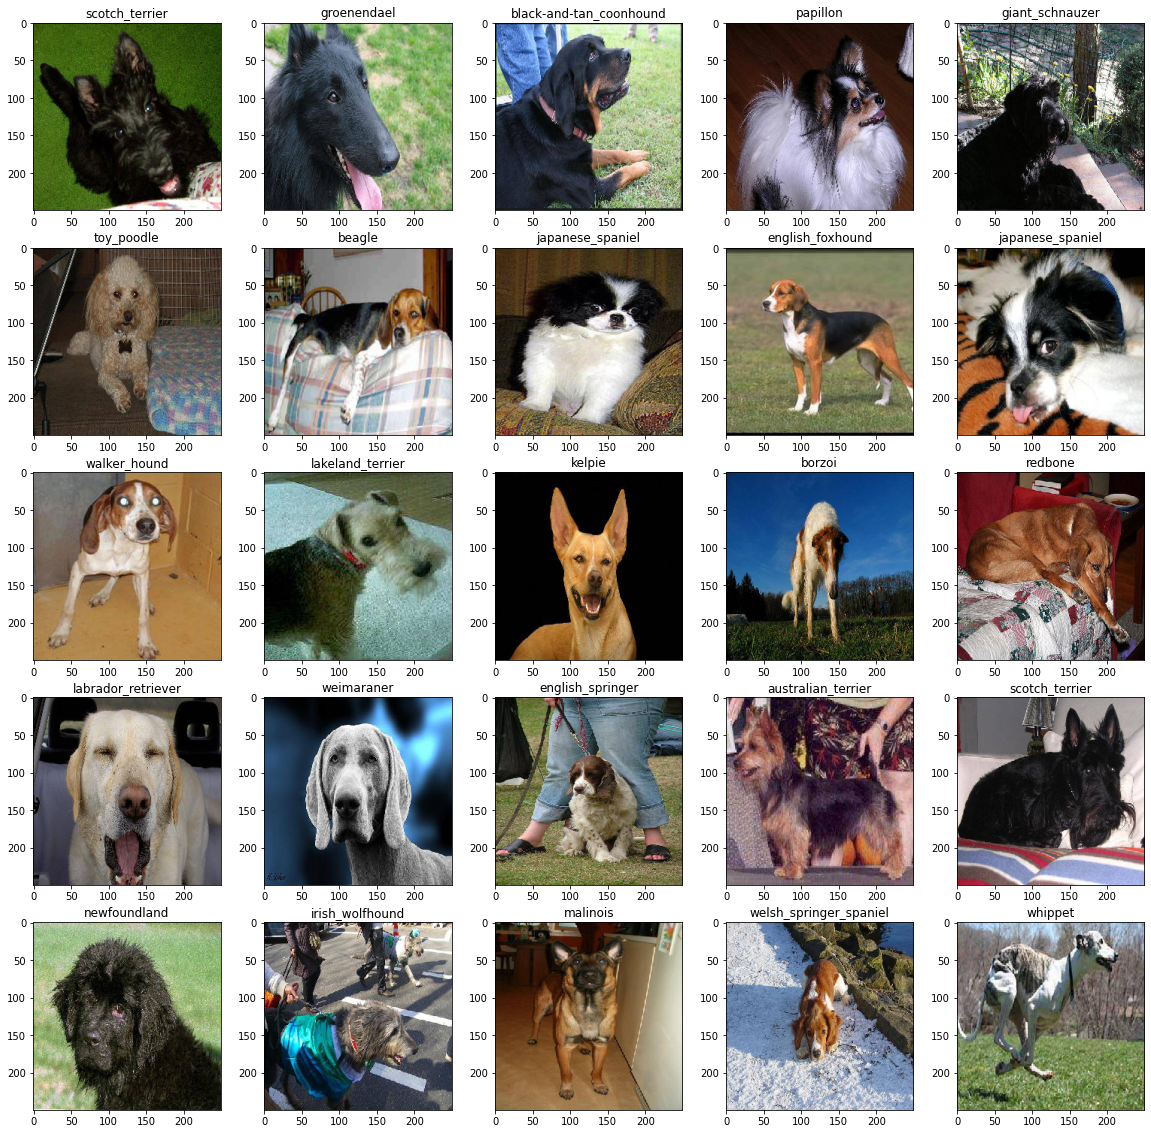

In [60]:
plt.figure(figsize=(20,20))

for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.title(dog_breeds[np.where(y[i]==1)[0][0]])
    plt.imshow(X[i].astype('int32'))

**Definicija get_features funkcije**

Kreira se Lambda sloj i uvodi se GlobalAveragePooling2D() za filtriranje mape feature-a. Vrši se izdvajanje feature i unos se priprema za konvolucijsku neuronsku mrežu (CNN).

In [47]:
def get_features(model_name, data_preprocessor, input_size, data):

    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,
                            input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(data, batch_size=64, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps
    gc.collect()

**CNN - InceptionV3**

InceptionV3 je model koji pomaže prilikom analize fotografija i detekcije objekata i sastoji se iz 48 slojeva.

In [48]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
inception_features = get_features(InceptionV3,
                                  inception_preprocessor,
                                  img_size, X)

160/160 [==============================] - 1298s 8s/step
Feature maps shape:  (10222, 2048)


In [49]:
final_features = inception_features
print('Final feature maps shape', final_features.shape)

Final feature maps shape (10222, 2048)


**Uvođenje EarlyStopping callback-a**

EarlyStopping nam omogućava da njegovim pozivom pratimo određenu vrednost, u ovom slučaju 'val_loss', i da izazove prekid u epohama treniranja u slučaju da vrednosti u procesu krenu da opadaju (preciznost pogotka). Uz parametar restore_best_weights, vratiće se na najbolji mogući scenario treninga podataka, odnosno na trenutak pre pocetka opadanja vrednosti.

In [50]:
from keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

**Priprema DNN modela**

***Trening podataka***

Najveca preciznost je izmerena u 15.epohi i iznosi 0.8999.  Uz pomoć definisanog EarlyDropout callback-a, nas algoritam je sam razumeo da nije bilo potrebno ići dalje iako je definisano 60 epoha.

In [51]:
gc.collect()
#Prepare DNN model
dnn = keras.models.Sequential([
    InputLayer(final_features.shape[1:]),
    Dropout(0.7),
    Dense(n_classes, activation='softmax')
])

dnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#Train simple DNN on extracted features.
h = dnn.fit(final_features, y,
            batch_size=128,
            epochs=60,
            validation_split=0.1,
            callbacks=EarlyStop_callback)
gc.collect()

Epoch 1/60
72/72 [==============================] - 1s 12ms/step - loss: 2.6228 - accuracy: 0.4281 - val_loss: 0.6928 - val_accuracy: 0.7957
Epoch 2/60
72/72 [==============================] - 1s 11ms/step - loss: 0.8417 - accuracy: 0.7613 - val_loss: 0.5333 - val_accuracy: 0.8270
Epoch 3/60
72/72 [==============================] - 1s 10ms/step - loss: 0.6589 - accuracy: 0.8067 - val_loss: 0.5099 - val_accuracy: 0.8250
Epoch 4/60
72/72 [==============================] - 1s 10ms/step - loss: 0.5690 - accuracy: 0.8249 - val_loss: 0.5060 - val_accuracy: 0.8387
Epoch 5/60
72/72 [==============================] - 1s 10ms/step - loss: 0.5088 - accuracy: 0.8439 - val_loss: 0.4861 - val_accuracy: 0.8416
Epoch 6/60
72/72 [==============================] - 1s 11ms/step - loss: 0.4784 - accuracy: 0.8455 - val_loss: 0.5023 - val_accuracy: 0.8270
Epoch 7/60
72/72 [==============================] - 1s 11ms/step - loss: 0.4277 - accuracy: 0.8624 - val_loss: 0.5161 - val_accuracy: 0.8328
Epoch 8/60
72

1398

**Prikaz preciznosti istreniranog modela**

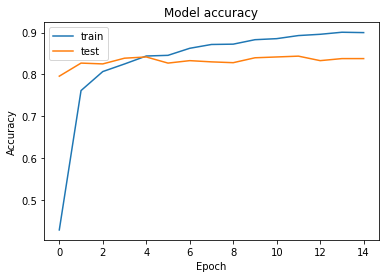

2878

In [54]:
keras.backend.clear_session()
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
gc.collect()

**Testiranje modela**

Definicija funkcije za čitanje podataka iz test direktorijuma i ponavljanje ubacivanje slika u niz

In [55]:
gc.collect()
def images_to_array2(data_dir, labels_dataframe, img_size = (224,224,3)):

    images_names = labels_dataframe['id']
    data_size = len(images_names)
    X = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)
    
    for i in tqdm(range(data_size)):
        image_name = images_names[i]
        img_dir = os.path.join(data_dir, image_name+'.jpg')
        img_pixels = tf.keras.preprocessing.image.load_img(img_dir, target_size=img_size)
        X[i] = img_pixels
        
    print('Ouptut Data Size: ', X.shape)
    return X

test_data = images_to_array2(test_dir, sample_df, img_size)

100%|██████████| 10357/10357 [00:41<00:00, 248.67it/s]

Ouptut Data Size:  (10357, 250, 250, 3)


In [56]:
#Extract test data features.
inception_features = get_features(InceptionV3, inception_preprocessor, img_size, test_data)

test_features = inception_features
print('Final feature maps shape', test_features.shape)

162/162 [==============================] - 1313s 8s/step
Feature maps shape:  (10357, 2048)
Final feature maps shape (10357, 2048)


In [57]:
y_pred = dnn.predict(test_features, batch_size=128)

81/81 [==============================] - 1s 10ms/step


**Upisivanje rezultata predikcije u csv fajl**

In [58]:
for b in dog_breeds:
    sample_df[b] = y_pred[:,class_to_num[b]]
sample_df.to_csv('/content/submission_predictions.csv', index=None)